<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Полезные-ссылки:" data-toc-modified-id="Полезные-ссылки:-0.0.1"><span class="toc-item-num">0.0.1&nbsp;&nbsp;</span><font color="orange">Полезные ссылки:</font></a></span></li></ul></li><li><span><a href="#Общее-впечатление" data-toc-modified-id="Общее-впечатление-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span><font color="orange">Общее впечатление</font></a></span></li><li><span><a href="#Общее-впечатление-(ревью-2)" data-toc-modified-id="Общее-впечатление-(ревью-2)-0.2"><span class="toc-item-num">0.2&nbsp;&nbsp;</span><font color="orange">Общее впечатление (ревью 2)</font></a></span></li></ul></li><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit
import lightgbm as lgb
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/datasets/taxi.csv')

In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


В нашем датасете 26496 записей с количеством заказов на каждый 10 минутный интервал времени.
Пропуски отсутствуют.
 
Приведём признак datetime к типу datetime

In [5]:
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

In [6]:
#выполним ресемплинг на на 1 часовой интервал и установим время как индекс 
data = data.set_index('datetime').resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Вывод**

 - загрузили данные, не обнаружили пропуски;
 - выполнили ресемплинг на 1 часовой интервал

## Анализ

Посмотрим какой у нас интервал данных 

In [7]:
print(f'Начало периода: {data.index.min()}')
print(f'Конец периода:   {data.index.max()}')

Начало периода: 2018-03-01 00:00:00
Конец периода:   2018-08-31 23:00:00


Построим график

<AxesSubplot:xlabel='datetime'>

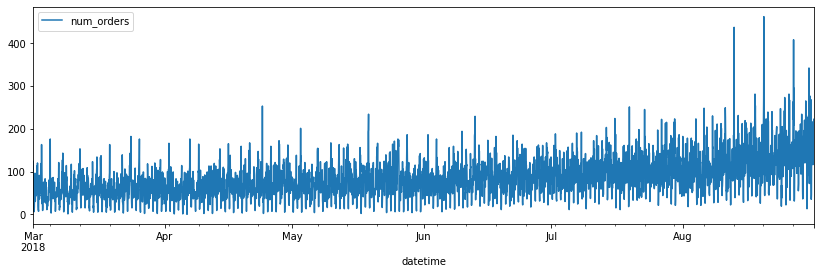

In [8]:
data.plot(figsize=(14,4))

Проверим есть ли циклично повторяющиеся закономерности 

<AxesSubplot:xlabel='datetime'>

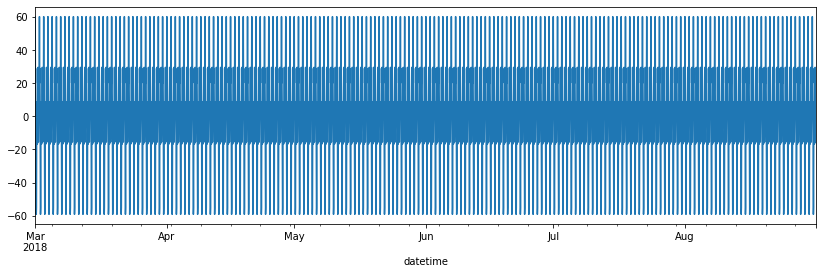

In [9]:
decomposed = seasonal_decompose(data)
decomposed.seasonal.plot(figsize=(14,4))

Построим для одной недели, так как сезонность имеет очень маленький период

<AxesSubplot:xlabel='datetime'>

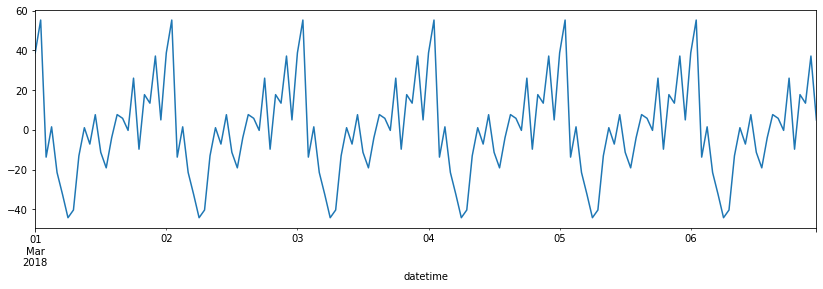

In [10]:
seasonal_decompose(data['2018-03-01':'2018-03-6']).seasonal.plot(figsize=(14,4))

Наблюдаем проявление сезонности ежедневно: больше всего заказов к концу дня, а меньше всего ночью

Проверим проявляется ли тренд за выбранный период

<AxesSubplot:xlabel='datetime'>

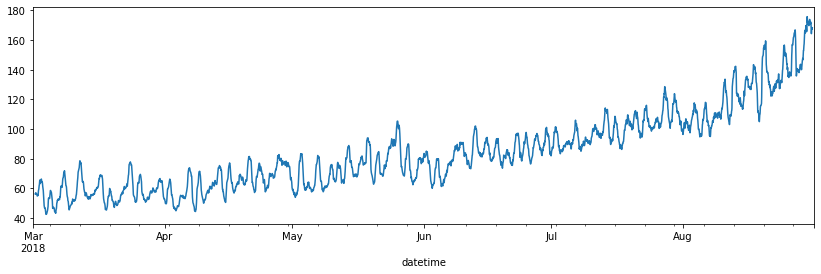

In [11]:
decomposed.trend.plot(figsize=(14,4))

Видим  увеличение количества заказов с конца весны, до конца лета

Построим график изменения количества заказов 

<AxesSubplot:xlabel='datetime'>

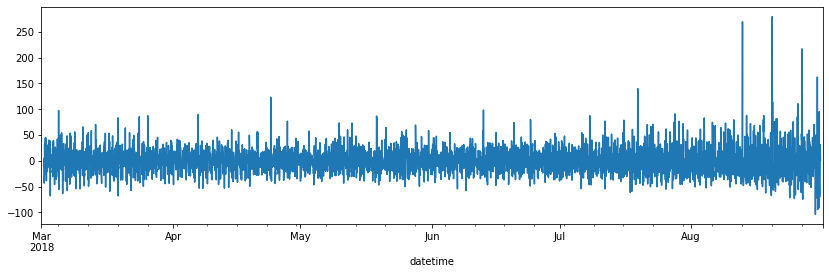

In [12]:
decomposed.resid.plot(figsize=(14,4))

Можем отметить, что волатильность изменений количества заказов к концу лета выше.

**Вывод**

Видим, что есть дневная сезонность, восходящий тренд, волатильность изменений количества заказов к концу лета выше.

## Обучение

Создадим функцию которая создаст дополнительные параметры

In [13]:

def make_features(data, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    # отстающие значения
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    # скользящее среднее    
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()


make_features(data, 170, 20)
print(data.head())

                     num_orders  day  dayofweek  hour  lag_1  lag_2  lag_3  \
datetime                                                                     
2018-03-01 00:00:00         124    1          3     0    NaN    NaN    NaN   
2018-03-01 01:00:00          85    1          3     1  124.0    NaN    NaN   
2018-03-01 02:00:00          71    1          3     2   85.0  124.0    NaN   
2018-03-01 03:00:00          66    1          3     3   71.0   85.0  124.0   
2018-03-01 04:00:00          43    1          3     4   66.0   71.0   85.0   

                     lag_4  lag_5  lag_6  ...  lag_162  lag_163  lag_164  \
datetime                                  ...                              
2018-03-01 00:00:00    NaN    NaN    NaN  ...      NaN      NaN      NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...      NaN      NaN      NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...      NaN      NaN      NaN   
2018-03-01 03:00:00    NaN    NaN    NaN  ...      NaN      NaN      NaN 

In [14]:
# Разделение исходного датафрейма на тренировочный и тестовый
train, test = train_test_split(data, shuffle=False, test_size = 0.1, random_state = 12345)
print('Проверка минимального и максимального значений индексов для тренировочного датасета: ', 
      train.index.min(), train.index.max())
print('Проверка минимального и максимального значений индексов для тестового датасета: ', 
      test.index.min(), test.index.max())
train = train.dropna()
train, valid = train_test_split(train, shuffle=False, test_size=0.3, random_state=12345)

Проверка минимального и максимального значений индексов для тренировочного датасета:  2018-03-01 00:00:00 2018-08-13 13:00:00
Проверка минимального и максимального значений индексов для тестового датасета:  2018-08-13 14:00:00 2018-08-31 23:00:00


In [15]:
features_train = train.drop(['num_orders'], axis = 1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_test = test['num_orders']
features_valid = valid.drop(['num_orders'], axis = 1)
target_valid = valid['num_orders']

*Линейная регрессия*

In [16]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
predict_lr_valid = model_lr.predict(features_valid)
rmse_lr_valid = mean_squared_error(np.array(target_valid), predict_lr_valid)**0.5
print('RMSE на валидационной выборке:', rmse_lr_valid)

RMSE на валидационной выборке: 25.76820560061727


*CatBoost*

In [17]:
model_cb = CatBoostRegressor(random_state = 12345, iterations = 300)
parameters_cb = {'depth': range(6, 11),
                 'learning_rate': [0.001, 0.01, 0.05, 0.1]}
tscv = TimeSeriesSplit(n_splits=5)
search_cb = RandomizedSearchCV(model_cb, parameters_cb, cv = tscv, n_jobs = -1, random_state = 12345)
search_cb.fit(features_train, target_train, verbose = 100)
best_cb = search_cb.best_estimator_
predict_cb_valid = best_cb.predict(features_valid)
rmse_cb_valid = mean_squared_error(np.array(target_valid), predict_cb_valid)**0.5
print('RMSE на валидационной выборке:', rmse_cb_valid)

0:	learn: 29.7813890	total: 287ms	remaining: 1m 25s
100:	learn: 20.7086935	total: 14.2s	remaining: 27.9s
200:	learn: 15.6953842	total: 28s	remaining: 13.8s
299:	learn: 12.5480414	total: 41.7s	remaining: 0us
0:	learn: 29.2103570	total: 280ms	remaining: 1m 23s
100:	learn: 20.0630148	total: 16.3s	remaining: 32.2s
200:	learn: 15.7766821	total: 32.1s	remaining: 15.8s
299:	learn: 13.3073219	total: 47.9s	remaining: 0us
0:	learn: 30.7022562	total: 293ms	remaining: 1m 27s
100:	learn: 20.9048787	total: 18.2s	remaining: 35.9s
200:	learn: 16.5793384	total: 36.3s	remaining: 17.9s
299:	learn: 14.1472145	total: 53.5s	remaining: 0us
0:	learn: 31.8352005	total: 311ms	remaining: 1m 32s
100:	learn: 21.6212365	total: 18.8s	remaining: 37s
200:	learn: 17.3015783	total: 37.1s	remaining: 18.3s
299:	learn: 15.0448065	total: 55.2s	remaining: 0us
0:	learn: 32.7676204	total: 325ms	remaining: 1m 37s
100:	learn: 22.0609180	total: 20s	remaining: 39.5s
200:	learn: 17.8596108	total: 39.8s	remaining: 19.6s
299:	learn: 

In [18]:
data_model = [['LinearRegression', rmse_lr_valid], 
              ['CatBoost', rmse_cb_valid]]
columns_model = ['model', 'rmse']
table_model = pd.DataFrame(data = data_model, columns = columns_model)
table_model

,model,rmse
0,LinearRegression,25.768206
1,CatBoost,27.754644


## Тестирование

Выберем и протестируем лучшую модель, в данном случае LinearRegression оказалась более точной

In [19]:
predict_lr_test = model_lr.predict(features_test)
rmse_lr_test = mean_squared_error(np.array(target_test), predict_lr_test)**0.5
print('Качество модели Linear Regression на тестовой выборке:', rmse_lr_test)


Качество модели Linear Regression на тестовой выборке: 36.2939469289


<div class="alert alert-block alert-info">
<b>Совет: </b> Финальные предсказания можно было визуализирвоать: графики исходного и предсказанных рядов.
</div>

**Вывод**


Целью проекта было создание модели, способной предсказать спрос на услуги такси с отклонением до 48 заказов в час.

Мы обучили две модели, наиболее точной оказалась LinearRegression. Проверив ее на тестовой выборке, ее отклонение составило 36, что удовлетворяет нашей задаче по получению отклонения до 48 заказов в час. 

Учитывая, что  мы наблюдали  тренд на увеличение заказов, которые сложно прогноризуются в "начале" сезона,  результат можно считать неплохим. 

Цели и задачи исследования достигнуты, однако для улучшения метрики стоит взять больший период времени.